In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr
import seaborn as seabornInstance 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn import datasets
%matplotlib inline

# Reproduce the work from journal: 
### Candanedo, L., Feldheim, V. and Deramaix, D. (2017). Data driven prediction models of energy use of appliances in a low-energy house. Energy and Buildings, 140, pp.81-97.

### Objective of The Experiment
The purpose of this experiment is to understand the relationships between the appliances' energy consumption with different predictors. Using the data from the experiment, we would also want to be able to do a prediction of the appliances' energy consumption and also to obtain wich predictors give a significant effect to the energy consumption. 

The energy consumption information is collected with an internet-connected energy monitoring system where it is collected in 10 minutes interval, and then stored and reported by e-mail every 12 hour.

In [2]:
#Import the energydata_complete.csv and use 'date' as the index of the rows
energy = pd.read_csv('data/energydata_complete.csv', index_col='date', parse_dates=True)

energy.index = energy.index.tz_localize('UTC') #Set column as time

#Extracting the year, month, date of the day, day, and hour for further data analysis later
energy['Year'] = energy.index.year
energy['Month'] = energy.index.month
energy['Day'] = energy.index.day
energy['Weekday Name'] = energy.index.weekday_name
energy['Hour'] = energy.index.hour
energy['Weekday Code'] = energy.index.weekday #for linear regression

# Giving code for weekend = 1 and weekday = 0
energy.loc[energy['Weekday Code'] > 4, 'Weekend or Not'] = 1
energy.loc[energy['Weekday Code'] <= 4, 'Weekend or Not'] = 0

# Calculating NSM
time = pd.to_datetime(energy.index)
energy['NSM'] = time.hour*36000+time.minute*60+time.second

energy.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,rv1,rv2,Year,Month,Day,Weekday Name,Hour,Weekday Code,Weekend or Not,NSM
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00+00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,13.275433,13.275433,2016,1,11,Monday,17,0,0.0,612000
2016-01-11 17:10:00+00:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.606195,18.606195,2016,1,11,Monday,17,0,0.0,612600
2016-01-11 17:20:00+00:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,28.642668,28.642668,2016,1,11,Monday,17,0,0.0,613200
2016-01-11 17:30:00+00:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.410389,45.410389,2016,1,11,Monday,17,0,0.0,613800
2016-01-11 17:40:00+00:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,10.084097,10.084097,2016,1,11,Monday,17,0,0.0,614400


### Variability of the Appliances Energy Consumption

The time span of the data set is 137 days (4.5 months). The diagram below shows the energy consumption for the whole period and also the first week period. From the both diagrams below, it can be seen that the energy consumption profile shows a high variability.

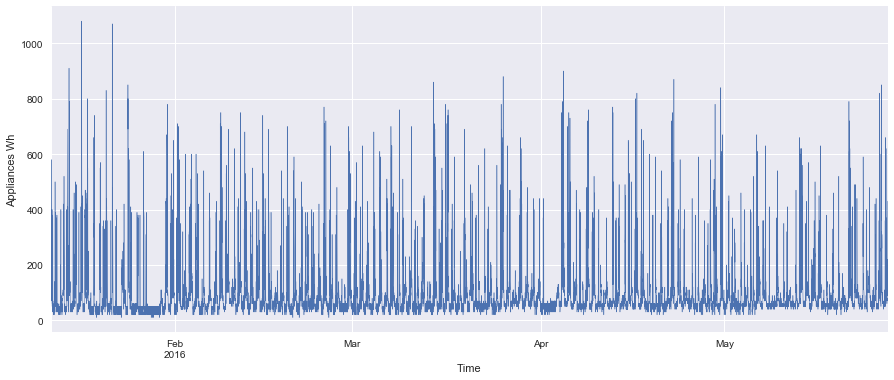

In [4]:
#Line plot over the experiment period

fig, ax = plt.subplots(figsize=(15,6))
energy['Appliances'].plot(linewidth=0.5);
ax.set_ylabel('Appliances Wh')
ax.set_xlabel('Time')

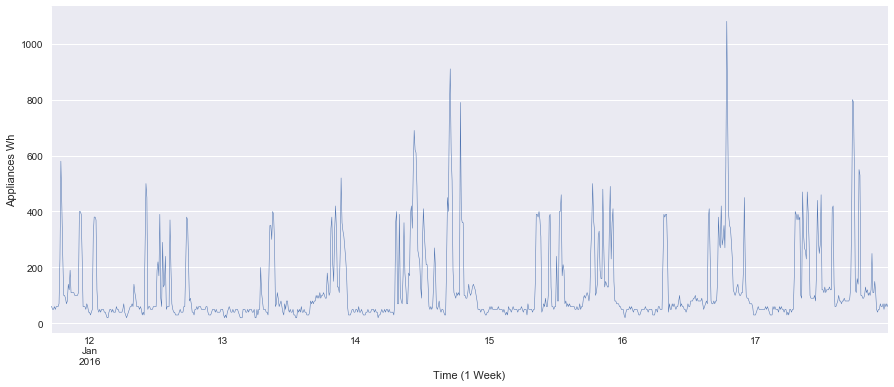

In [3]:
# Select 4 first week for further analysis later
firstweek=energy.loc['2016-1-11 00:00:00':'2016-1-17 23:59:59']
secondweek=energy.loc['2016-1-18 00:00:00':'2016-1-24 23:59:59']
thirdweek=energy.loc['2016-1-25 00:00:00':'2016-1-31 23:59:59']
fourthweek=energy.loc['2016-2-1 00:00:00':'2016-2-7 23:59:59']

# Line plot of the appliances energy consumption for 1 week
fig, ax = plt.subplots(figsize=(15,6))
firstweek['Appliances'].plot(linewidth=0.5);

ax.set_ylabel('Appliances Wh')
ax.set_xlabel('Time (1 Week)')

### Distribution of the Appliances Energy Consumption
From the histogram and box plot diagram below, it can be seen that the appliances energy consumption data has a long tail. The median of the data represented by the blue line inside the box, where it is more dispered. We can also see that there are several outliers in the data shown by the circle.

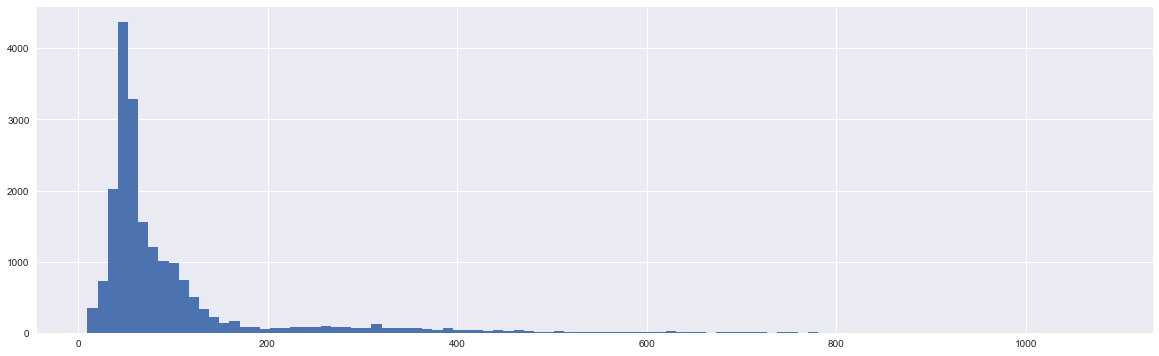

In [4]:
plt.figure(figsize=(20,6))
plt.hist(energy['Appliances'],bins=100)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


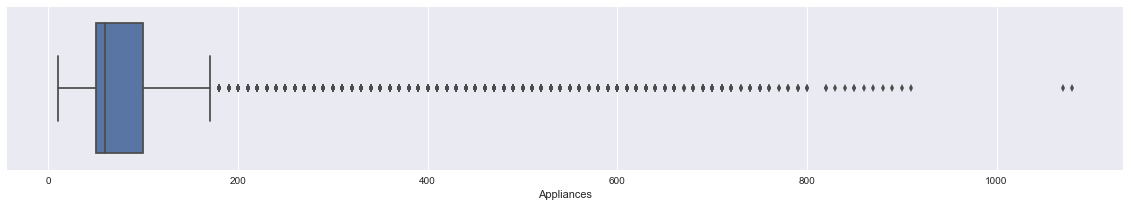

In [14]:
plt.figure(figsize=(20,3))
sns.boxplot(x=energy['Appliances'], vert=False)

It can be seen from the histogram and barplot above the energy data distribution has a really long tail

### Relationship between the Appliances Energy Consumption and all variables

The pairplot diagrams below showing the relationship between all the variables with the energy consumption of appliances ('Appliances'). 

Scatter plot in the lower diagonal show how the two variables intreact. While in the diagonal, a distribution of the variables can be seen in the histogram diagram. Whereas in the upper diagonal, the Pearson correlation coeficient between the two variables shown. A correlation of 1 is total high positive correlation, -1 is total negatve correlation, and 0 represents no correlation.

In [9]:
# Defining the correlation fuction
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.text(0.1, 0.1, "{0:.2f}".format(r),
        transform=ax.transAxes,
        color='black', fontsize=60)

# Defining the function of pairplot diagram
def pairplotdiagram(variables):
    g = sns.PairGrid(energy, vars=variables)
    g.map_lower(sns.regplot, color="0",line_kws={"color":"r","alpha":0.7,"lw":2}, scatter_kws={'s':5})
    g.map_upper(corrfunc)
    g.map_diag(sns.distplot,hist_kws={"color":"cyan"},kde_kws={"color":"black","lw":1})

In [15]:
# Defining the variables in each pairplot diagram
list1=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
list2=['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
list3=['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
list4=['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM','T6']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


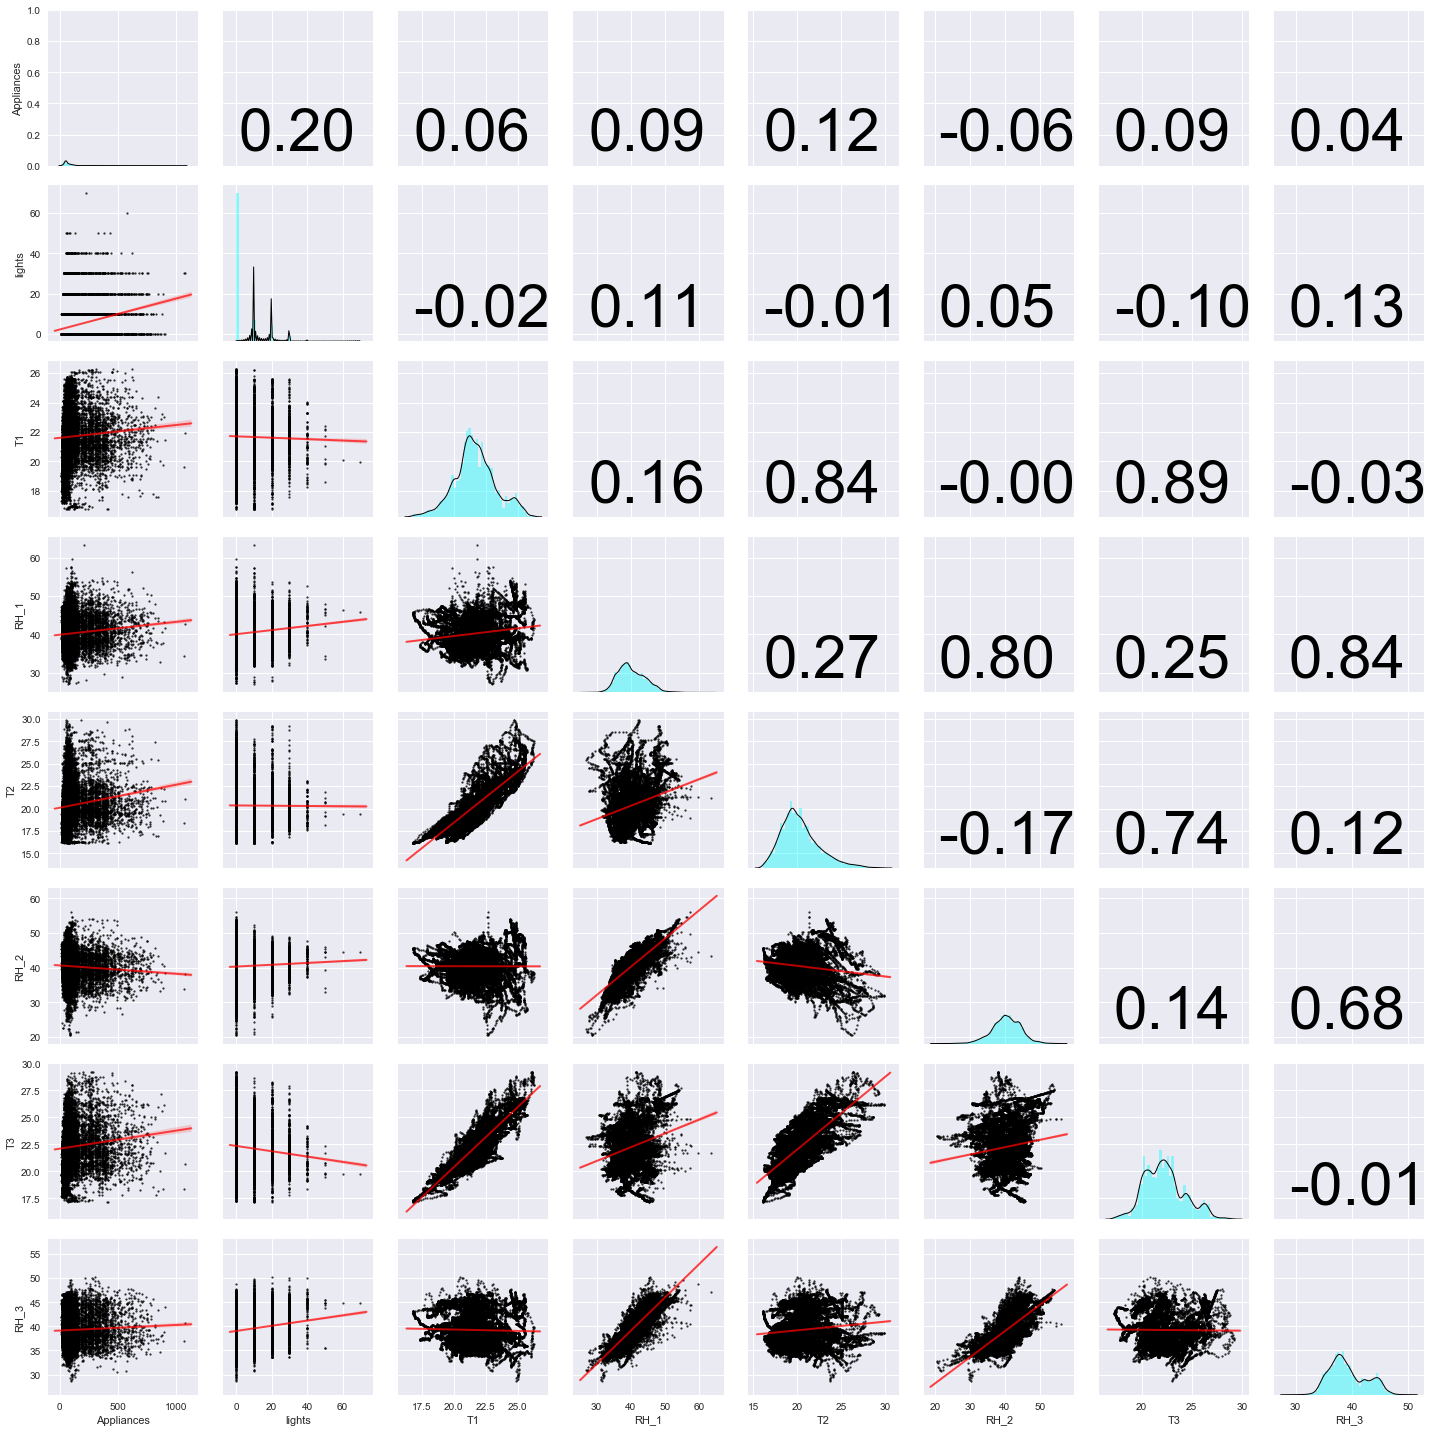

In [11]:
# Print the first pairplot diagram

pairplotdiagram(list1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


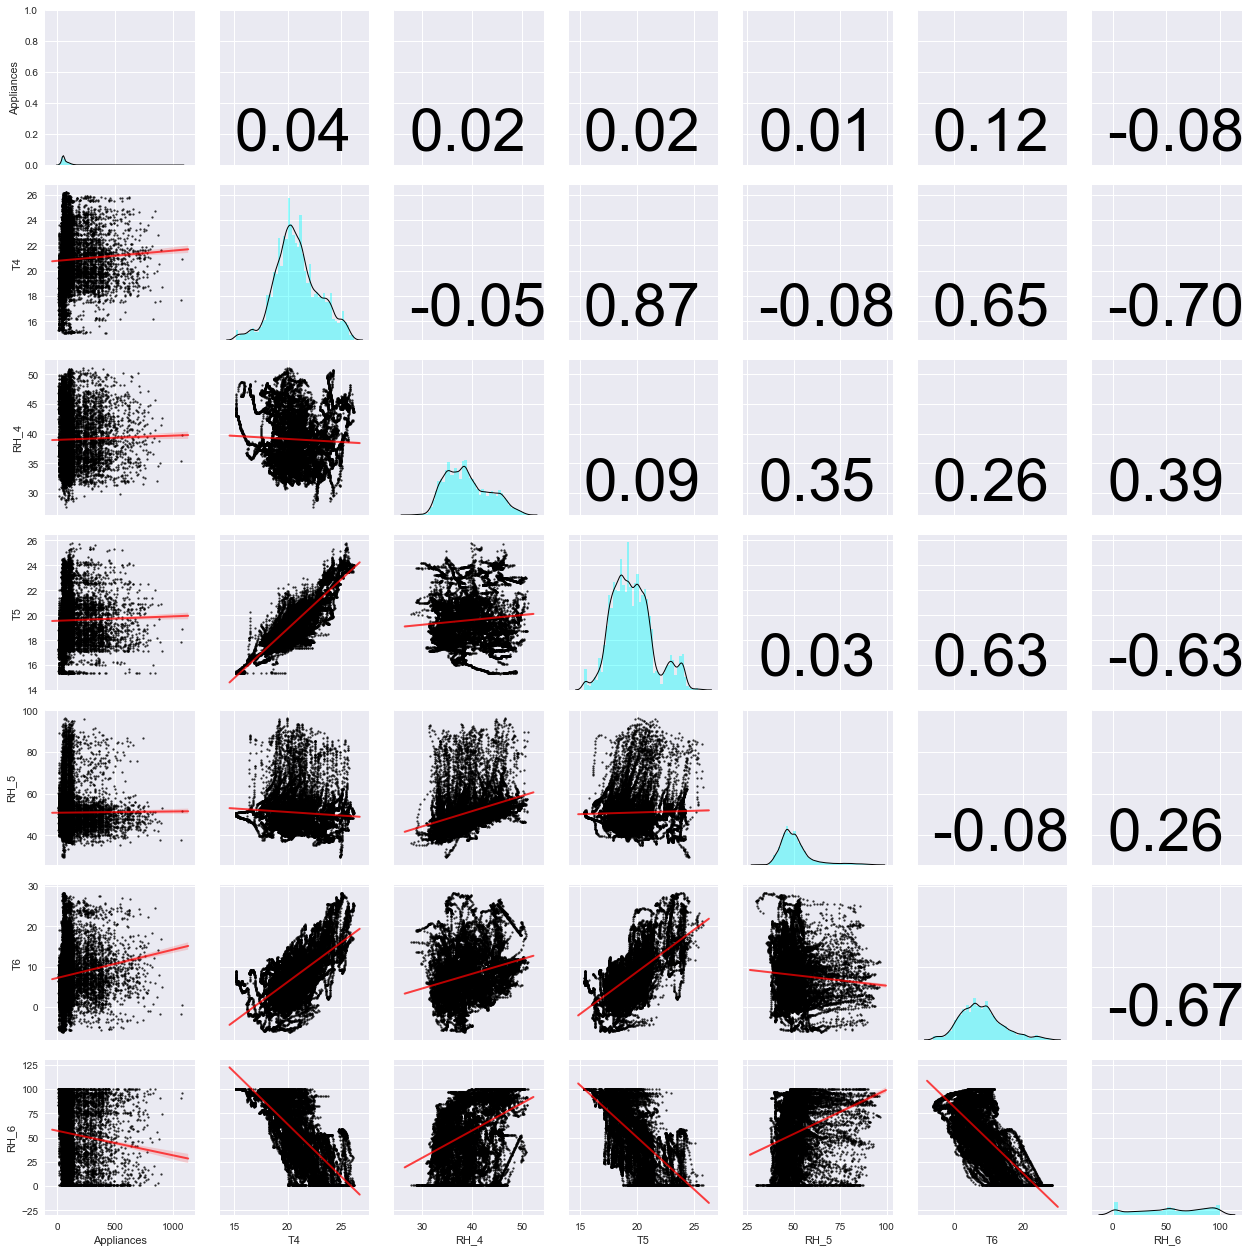

In [12]:
# Print the second pairplot diagram

pairplotdiagram(list2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


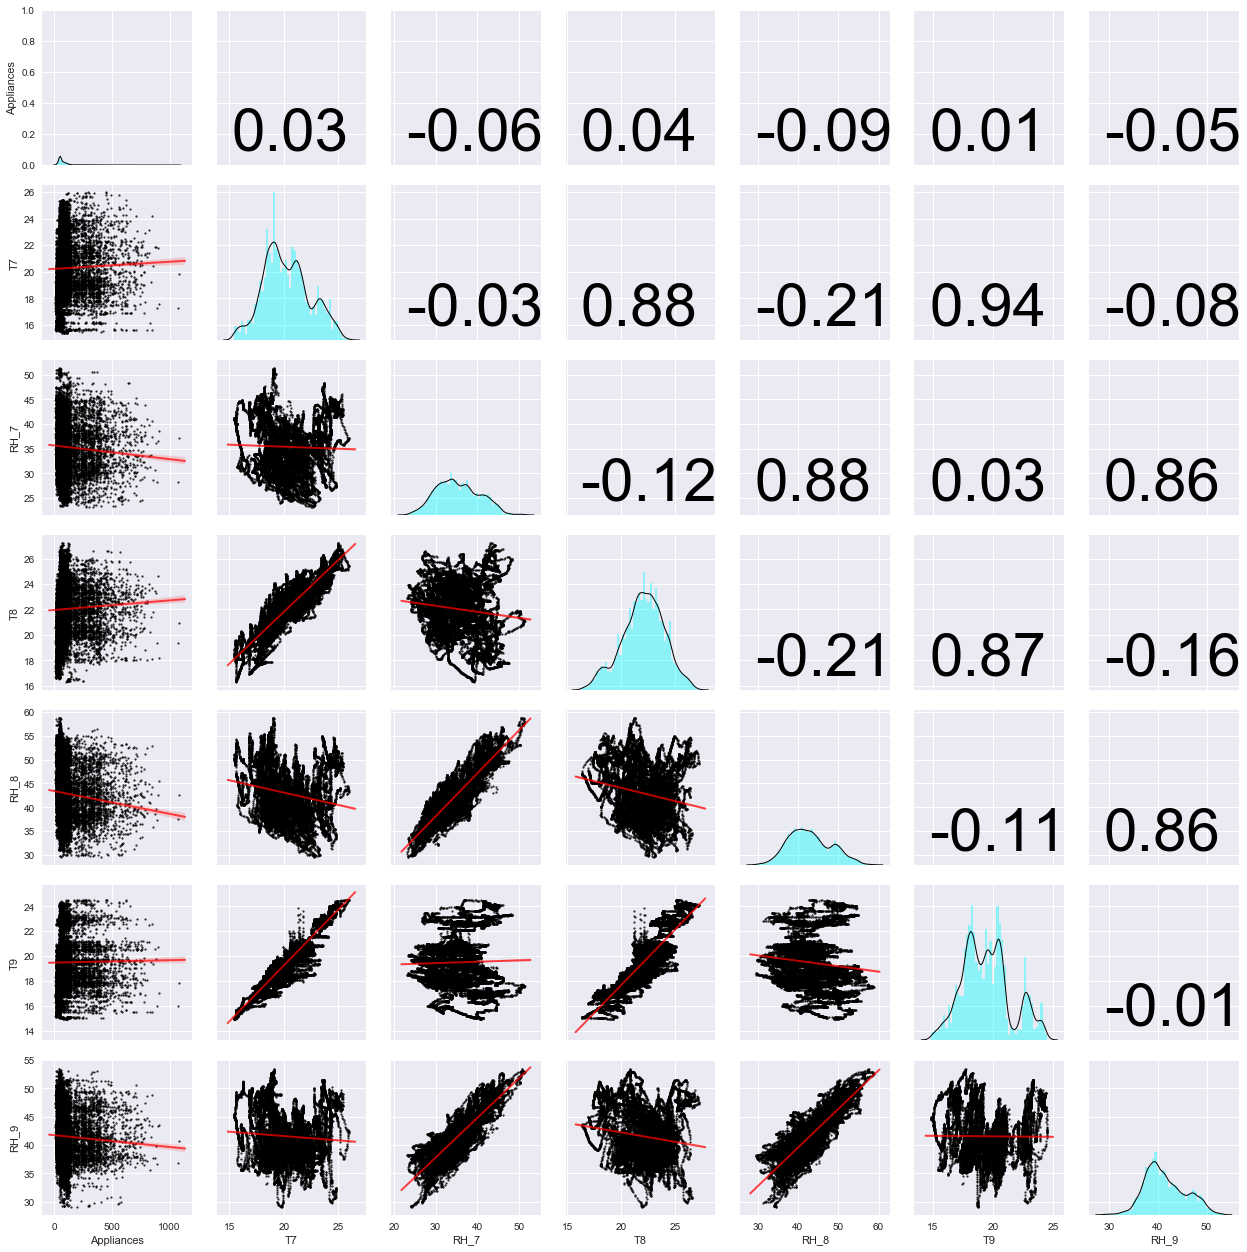

In [16]:
# Print the third pairplot diagram

pairplotdiagram(list3)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


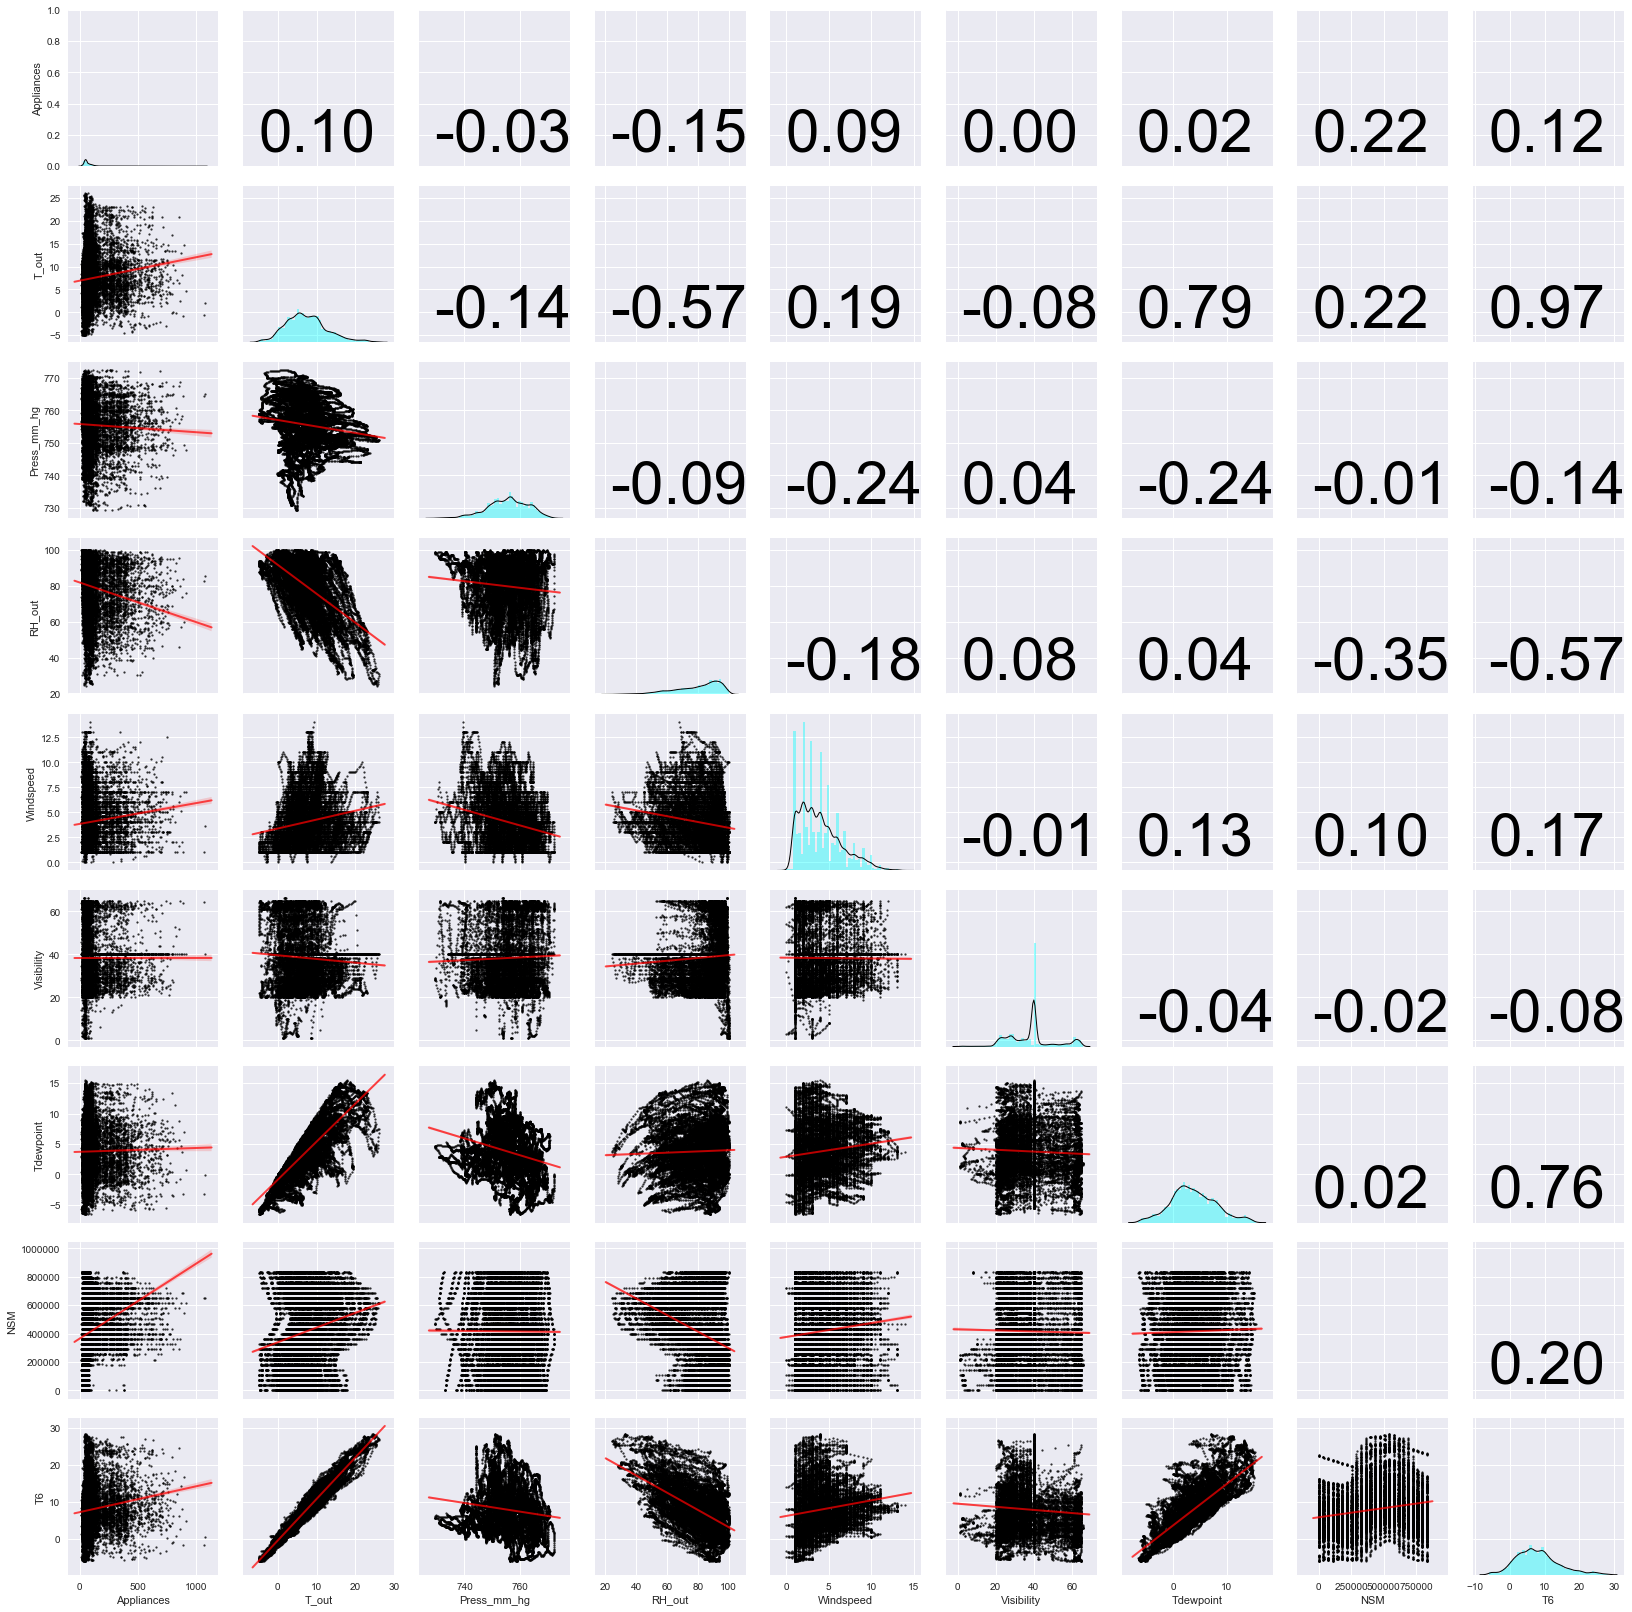

In [17]:
# Print the fourth pairplot diagram

pairplotdiagram(list4)

From the pairplot diagrams above, we can focus on the first line of each diagram to see the correlations coeficient between the appliances energy consumption (Appliances) and other variables. Where, correlation with the 'Lights' variables shown to be the highest with coeficient of 0.20

### Time Trend Identification
An hourly heat map was created for four consecutive weeks of the Appliances Energy Consumption to identify andy time trends. As can be clearly seen, there is a strong time component in the energy consumption pattern. The energy consumption start to rise around 6 in the morning. Then around noon, there are a significant escalation. In term of day of the week, the clear pattern can not be clearly identified.

In [18]:
# Summing Up the Energy Consumption of 10 minutes into an hour total, calculation done for each week

heatmap1=firstweek.groupby(['Day','Hour']).agg('sum')
heatmap2=secondweek.groupby(['Day','Hour']).agg('sum')
heatmap3=thirdweek.groupby(['Day','Hour']).agg('sum')
heatmap4=fourthweek.groupby(['Day','Hour']).agg('sum')

In [19]:
# Defining a fuction to produce the heatmap

def heatmapfigure(xxx):
    #reset the index
    heatmap1_=xxx.reset_index()
    #Make a Pivot by Hour, Day, and the Value is the Appliances
    heatmap_1 = heatmap1_.pivot("Hour", "Day", "Appliances")
    #Make the heatmap
    f, ax = plt.subplots(figsize=(2.5, 6))
    g = sns.heatmap(heatmap_1, cmap="YlOrRd")
    g.set_facecolor('#ffffcc')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #To give day label on the heatmap
    ax.set_xticklabels(days)
    plt.xticks(rotation=90) #Rotate the label so it can be read clearly

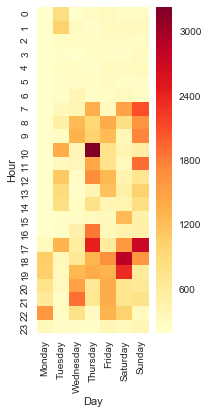

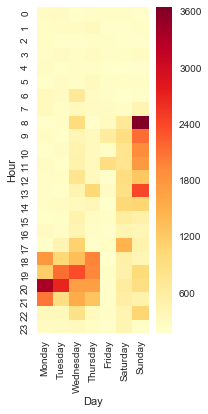

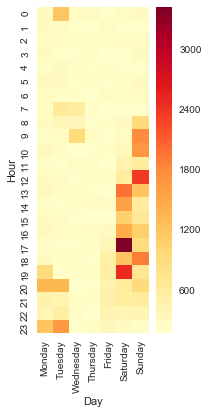

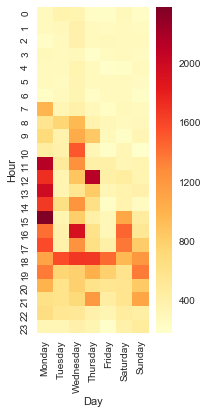

In [20]:
heatmapfigure(heatmap1)
heatmapfigure(heatmap2)
heatmapfigure(heatmap3)
heatmapfigure(heatmap4)

From the heatmap diagram above, it can be seen that there is clearly __a trend in the time axis__, where the __energy tends to increase around 6-8 am__, and it __goes low again around 10-11 pm__. While in the day of the week, we can not clearly see a trend based on the day trend from the 4 week illustration.

## Linear Regression

We use linear regression to be the model that will be used to predict the energy consumption. The data separated to the train and test data, so the model later can be evaluated.

In [21]:
# Separating data randomly, 25% test, 75% train

train, test = train_test_split(energy, test_size=0.25)

# Check the number of the data for the test and train
print(test.shape)
print(train.shape)

(4934, 36)
(14801, 36)


We define the X as all the independent variables, and Y as the dependent variable (the outcome of independent variables)

In [22]:
#Defining X_train, y_train, X_test, y_test

X_train = train[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Weekday Code', 'Weekend or Not', 'NSM']]
y_train = train[['Appliances']]
X_test = test[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Weekday Code', 'Weekend or Not', 'NSM']]
y_test = test[['Appliances']]

The linear regression equation from the train data:

In [23]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[  1.83778771e+00  -3.19538204e+00   1.28252283e+01  -1.66292395e+01
   -1.24544063e+01   2.61269089e+01   6.49279975e+00  -1.94402486e+00
   -7.43125132e-01  -7.58469690e-01   7.88488370e-02   7.57774723e+00
    2.65395490e-01   2.25078619e+00  -1.63083042e+00   6.77172819e+00
   -4.02782295e+00  -1.41309039e+01  -4.92583258e-01  -1.11929588e+01
    2.22295602e-01  -9.92075817e-01   1.87705963e+00   1.62791478e-01
    5.10698276e+00   1.08779608e+00   3.48249333e+00   2.85577366e-05]] + [-68.89801742]


We need to evaluate the RMSE, R squared, MAE, MAPE, and MSE to evaluate our linear model

In [26]:
# Predicting the outcome of the model from the test data
y_pred = reg.predict(X_test)

# Calculate the MAE, MSE, and RMSE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print() #Space
print('R Squared:', r2_score(y_test, y_pred))  
print() #Space
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))  
print() #Space
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_test, y_pred),'%')
print() #Space
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))  


Root Mean Squared Error (RMSE): 94.4452645374

R Squared: 0.173302703081

Mean Absolute Error (MAE): 53.0862063375

Mean Absolute Percentage Error (MAPE): 60.472282592 %

Mean Squared Error (MSE): 8919.90799354


__Analysis:__

The number of our RMSE, Rsquared, MAE, and MAPE are about the same with what on the journal paper (there is a slightly different, but it happens because we separate our train and test data differently)

ValueError: Argument dimensions are incompatible

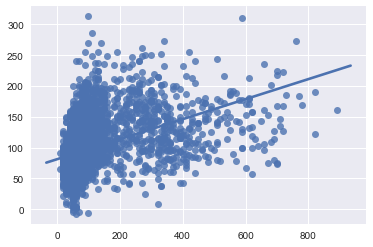

In [31]:
# Residual Plot where Y is the residual
ax1=sns.regplot(y_test['Appliances'], y_pred)

# Feature Selection

In [36]:
# Use linear regression as the model
lr = LinearRegression()
# Rank all features
rfe = RFE(lr, 1) # Using 1 so the ranking will be from 1 to 28
rfe.fit(energy[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Weekday Code', 'Weekend or Not', 'NSM']],energy[['Appliances']])

print(rfe.ranking_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[13 21  1  3  2  4 11 12 27 26 24  9 22 17 15  6  8  5 19 10 25 20 14 23 18
 16  7 28]


In [40]:
# Making a new dataframe to see it clearly
df = pd.DataFrame(rfe.ranking_, columns=['Ranking'],) 
# Add new column: Features
df['Features'] = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Weekday Code', 'Weekend or Not', 'NSM']
# Sort the features based on ranking
df.sort_values(by=['Ranking']).reset_index(drop=True)

,Ranking,Features
0,1,RH_1
1,2,RH_2
2,3,T2
3,4,T3
4,5,T9
5,6,T8
6,7,Weekend or Not
7,8,RH_8
8,9,T6
9,10,T_out


It can be seen that the RFE from our data shows a difference from the journal paper.